In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import plotly.express as px
pd.options.display.max_colwidth = 350
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Dict, List

In [2]:
def print_vif(
    df: pd.DataFrame = None,
    exog: List = None,
) -> None:
    """Calculate the VIF for each variable using statsmodels

    :param df: dataframe, defaults to None
    :type df: pd.DataFrame, optional
    :param exog: list with exogenous variables names, defaults to None
    :type exog: List, optional
    """
    
    vif = dict()
    for i, var in enumerate(exog):
        vif[var] = variance_inflation_factor(exog=df[exog], exog_idx=i).round(2)

    display(pd.DataFrame.from_dict(data=vif, orient='index', columns=['VIF']))

In [3]:
def read_data(file_path: str = None) -> pd.DataFrame:

    df = pd.read_csv(filepath_or_buffer=file_path)
    df.columns = df.columns.str.lower()
    df = df.drop(columns=['adj close']).copy()
    df = df.set_index(keys='date')
    df.index = pd.to_datetime(arg=df.index)
    df = df.loc['2010-01-01': '2019-12-31'].copy()
    df['close_shift_1d'] = df['close'].shift(periods=1)
    df['const'] = 1
    return df

## Get data

In [4]:
amazon = read_data(file_path='AMZN.csv')
amazon

,open,high,low,close,volume,close_shift_1d,const
date,,,,,,,
2010-01-04,6.812500,6.830500,6.657000,6.695000,151998000,NaN,1
2010-01-05,6.671500,6.774000,6.590500,6.734500,177038000,6.695000,1
2010-01-06,6.730000,6.736500,6.582500,6.612500,143576000,6.734500,1
2010-01-07,6.600500,6.616000,6.440000,6.500000,220604000,6.612500,1
2010-01-08,6.528000,6.684000,6.451500,6.676000,196610000,6.500000,1
...,...,...,...,...,...,...,...
2019-12-24,89.690498,89.778503,89.378998,89.460503,17626000,89.650002,1
2019-12-26,90.050499,93.523003,89.974998,93.438499,120108000,89.460503,1
2019-12-27,94.146004,95.070000,93.300499,93.489998,123732000,93.438499,1


## Calculate indicators

The authors used a TTR (Technical Trading Rules) package for calculating technical indicators. [TTR](https://cran.r-project.org/web/packages/TTR/TTR.pdf) is an R package that provides the most popular technical analysis functions for financial market data, many of these functions are used as components of systematic trading strategies and financial charts. On page 8, the authors mentioned their use of the default number of cycles in the TTR package, which is why I need to align with this package.

### MACD
Moving Average Convergence Divergence is a special case of the general oscillator applied to price.

Docs in the TT package: MACD(x, nFast = 12, nSlow = 26, nSig = 9, maType, percent = TRUE, ...)

In [5]:
# https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/momentum/macd.py
amazon['macd'] = amazon['close_shift_1d'].ewm(span=12, min_periods=12).mean() - amazon['close_shift_1d'].ewm(span=26, min_periods=26).mean()
amazon['macd_pandas-ta'] = ta.macd(close=amazon['close_shift_1d'])['MACD_12_26_9']
amazon[['macd', 'macd_pandas-ta']]

,macd,macd_pandas-ta
date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,NaN,NaN
2010-01-07,NaN,NaN
2010-01-08,NaN,NaN
...,...,...
2019-12-24,0.254335,0.254335
2019-12-26,0.284445,0.284445
2019-12-27,0.622128,0.622128


### ROC
Rate of Change calculates the rate of change in the closing price within a certain period of time.

Docs in the TTR package: ROC(x, n = 1, type = c("continuous", "discrete"), na.pad = TRUE)

In [6]:
def calculate_roc(
    data: pd.Series = None,
    n: int = None
) -> pd.Series:
    
    # Calculate the ROC
    roc = data.pct_change(periods=n) * 100

    return roc

In [7]:
# https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/momentum/roc.py
amazon['roc'] = calculate_roc(data=amazon['close_shift_1d'], n=1)
amazon['roc_pandas-ta'] = ta.roc(close=amazon['close_shift_1d'], length=1)
amazon[['roc', 'roc_pandas-ta']]

,roc,roc_pandas-ta
date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,0.589993,0.589993
2010-01-07,-1.811567,-1.811567
2010-01-08,-1.701323,-1.701323
...,...,...
2019-12-24,0.363846,0.363846
2019-12-26,-0.211376,-0.211376
2019-12-27,4.446651,4.446651


### TRIX
Triple Smoothed Exponential Oscillator - it's an oscillator that combines trend with its momentum.

TRIX(price, n = 20, nSig = 9, maType, percent = TRUE, ...)

In [8]:
def calculate_trix(
    data: pd.Series = None,
    n: int = None
) -> pd.Series:

    # Calculate the n-period EMA of the price data
    ema1 = data.ewm(span=n, min_periods=30).mean()

    # Calculate the n-period EMA of the n-period EMA of the price data
    ema2 = ema1.ewm(span=n, min_periods=30).mean()

    # Calculate the n-period EMA of the n-period EMA of the n-period EMA of the price data
    ema3 = ema2.ewm(span=n, min_periods=30).mean()

    # Calculate the TRIX oscillator
    trix = 100*(ema3 - ema3.shift()) / ema3.shift()

    return trix

In [9]:
# https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/momentum/trix.py
amazon['trix'] = calculate_trix(data=amazon['close_shift_1d'], n=20)
amazon['trix_pandas-ta'] = ta.trix(close=amazon['close_shift_1d'], length=20)['TRIX_20_9']
amazon[['trix', 'trix_pandas-ta']]

,trix,trix_pandas-ta
date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,NaN,NaN
2010-01-07,NaN,NaN
2010-01-08,NaN,NaN
...,...,...
2019-12-24,-0.002885,-0.002885
2019-12-26,0.000966,0.000966
2019-12-27,0.008710,0.008710


### DPO
Detrended Price Oscillator removes trend from price and makes it easier to identify cycles.

Docs in the TTR package:  DPO(x, n = 10, maType, shift = n/2 + 1, percent = FALSE, ...)

In [10]:
def calculate_dpo(
    data: pd.Series = None,
    n: int = None
) -> pd.Series:
    
    # Calculate the moving average
    ma = data.rolling(window=n).mean().shift(int(n/2)+1)

    # Calculate the DPO
    dpo = data - ma

    return dpo

In [11]:
# https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/trend/dpo.py
amazon['dpo'] = calculate_dpo(data=amazon['close_shift_1d'], n=10)
amazon['dpo_pandas-ta'] = ta.dpo(close=amazon['close_shift_1d'], length=10, centered=False)
amazon[['dpo', 'dpo_pandas-ta']]

,dpo,dpo_pandas-ta
date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,NaN,NaN
2010-01-07,NaN,NaN
2010-01-08,NaN,NaN
...,...,...
2019-12-24,1.834801,1.834801
2019-12-26,1.707252,1.707252
2019-12-27,5.581748,5.581748


### CMO
Chande Momentum Oscillator - it's a modified RSI and divides the total movement by the net movement.

Docs in the TTR package: CMO(x, n = 14)

In [12]:
def calculate_cmo(
    data: pd.DataFrame = None,
    n: int = None,
) -> pd.Series:
    
    data['diff'] = data['close_shift_1d'].diff()
    data['up'] = data['diff'].clip(lower=0)
    data['down'] = -1*data['diff'].clip(upper=0)
    data['up_rolling'] = data['up'].rolling(window=n).sum()
    data['down_rolling'] = data['down'].rolling(window=n).sum()
    data['cmo'] = 100*(data['up_rolling'] - data['down_rolling']) / (data['up_rolling'] + data['down_rolling'])
    
    return data['cmo']

In [13]:
# Source: https://github.com/twopirllc/pandas-ta/issues/628
amazon['cmo'] = calculate_cmo(data=amazon, n=14)
amazon['cmo_pandas-ta'] = ta.cmo(close=amazon['close_shift_1d'], length=14, talib=False)
amazon[['cmo', 'cmo_pandas-ta']]

,cmo,cmo_pandas-ta
date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,NaN,NaN
2010-01-07,NaN,NaN
2010-01-08,NaN,NaN
...,...,...
2019-12-24,17.507633,17.507633
2019-12-26,22.613464,22.613464
2019-12-27,69.170266,69.170266


### RSI
Relative Strength Index - measures velocity/ magnitude of directional price movements.

Docs in the TTR package: RSI(price, n = 14, maType, ...). This will compute the 14-period RSI with Wilder's EMA smoothing unless you specify other values for n or maType when calling the function.

In [14]:
def calculate_rsi(
    data: pd.Series = None,
    n: int = None,
) -> pd.DataFrame:
    
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(alpha=1/n, min_periods=n).mean()
    avg_loss = loss.ewm(alpha=1/n, min_periods=n).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [15]:
# https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/momentum/rsi.py
amazon['rsi'] = calculate_rsi(data=amazon['close_shift_1d'], n=14)
amazon['rsi_pandas-ta'] = ta.rsi(close=amazon['close_shift_1d'], length=14)
amazon[['rsi', 'rsi_pandas-ta']]

,rsi,rsi_pandas-ta
date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,NaN,NaN
2010-01-07,NaN,NaN
2010-01-08,NaN,NaN
...,...,...
2019-12-24,57.514007,57.514007
2019-12-26,56.014289,56.014289
2019-12-27,72.327196,72.327196


Define a function for calculating all oscillators at once.

In [16]:
def get_oscillators(df: pd.DataFrame = None) -> pd.DataFrame:

    assert 'close_shift_1d' in df.columns
    df['trix'] = ta.trix(close=df['close_shift_1d'], length=20)['TRIX_20_9']
    df['macd'] = ta.macd(close=df['close_shift_1d'])['MACD_12_26_9']
    df['dpo'] = ta.dpo(close=df['close_shift_1d'], length=10, centered=False)
    df['cmo'] = ta.cmo(close=df['close_shift_1d'], length=14, talib=False)
    df['roc'] = ta.roc(close=df['close_shift_1d'], length=1)
    df['rsi'] = ta.rsi(close=df['close_shift_1d'], length=14)
    
    indicators = ['macd', 'rsi', 'cmo', 'trix', 'dpo', 'roc']
    df = df.dropna(subset=indicators).copy()

    return df

## Get prediction

In [17]:
amazon = read_data(file_path='AMZN.csv')
amazon = get_oscillators(df=amazon)

In [18]:
amazon['target'] = (amazon['close'].diff() > 0).astype(int)
features = ['const', 'macd', 'rsi', 'cmo', 'trix', 'dpo', 'roc']

In [19]:
# Multicollinearity is not a problem here
print_vif(df=amazon, exog=features)

,VIF
const,155.48
macd,3.72
rsi,8.35
cmo,5.34
trix,2.86
dpo,3.43
roc,1.30


The authors split the data set into two parts: a training set and a test set. The training set is used to fit the proposed models, and the test set is used to evaluate the prediction performances. It is difficult to give a general rule on how to choose the number of observations in each of the two parts. They used 70% of data for training, and 30% for testing.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(amazon[features], amazon['target'], train_size=0.7, shuffle=False)

To eliminate the scale effect from the different predictor variables, the authors make intragroup orthogonalization for the predictor variables. Features: `macd`, `rsi`, `cmo`, `trix`, `dpo`, and `roc` belong to the oscillator indicator group, so I will orthogonalize them effortlessly. One can orthogonalize a DataFrame in Python using various methods, but one common approach is to use the Gram-Schmidt process (authors did not mention their approach).

In [21]:
# Function to orthogonalize the DataFrame
def gram_schmidt(
    df: pd.DataFrame = None,
    features: List = None,
) -> pd.DataFrame:
    
    # QR decomposition
    Q, R = np.linalg.qr(df[features])
    orthogonalized_df = pd.DataFrame(data=Q, columns=features, index=df.index)
    return orthogonalized_df

In [22]:
oscillators = ['macd', 'rsi', 'cmo', 'trix', 'dpo', 'roc']
amazon.loc[y_train.index, oscillators] = gram_schmidt(df=amazon.loc[y_train.index, oscillators], features=oscillators)
amazon.loc[y_test.index, oscillators] = gram_schmidt(df=amazon.loc[y_test.index, oscillators], features=oscillators)

Authors apply the training set to learn the parameter estimators and the probability estimators for the two group penalized logistic regressions and adopt the test set to obtain confusion matrices and ROC curves to assess their prediction performances. They report the coefficient estimators for the group SCAD penalty for Amazon dataset in Eq. 12, page 11:
$$P(Y_t=1 | x_t) = \frac{e^{-0.6253-0.1405macd_t-0.698rsi_t-0.1155cmo_t-0.0946trix_t-1.1251dpo_t-0.1852roc_t}}{1 + e^{-0.6253-0.1405macd_t-0.698rsi_t-0.1155cmo_t-0.0946trix_t-1.1251dpo_t-0.1852roc_t}}$$


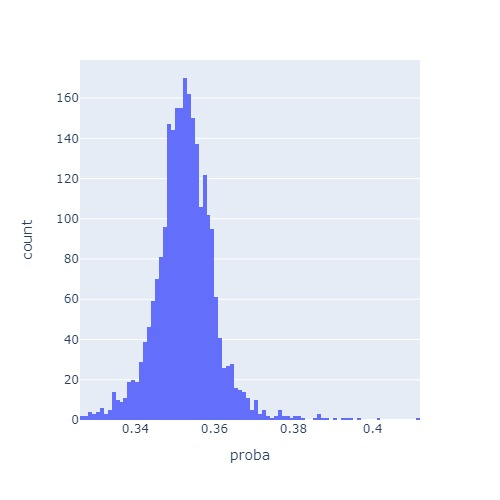

In [23]:
coefs_amazon = np.array([-0.6253, -0.1405, -0.698, -0.1155, -0.0946, -1.1251, -0.1852])
exp = np.exp(amazon[features].mul(coefs_amazon).sum(axis=1))
amazon['proba'] = exp / (1 + exp)
fig = px.histogram(data_frame=amazon, x='proba',  width=500, height=500)
fig.show('jpeg')

Authors estimate the predicted values Y_t different thresholds for each dataset and group penalized logistic regressions. Table 8 on page 13 lists the optimal thresholds selected by the Youden index for all cases. For group SCAD penalty for Amazon dataset, threshold is equal to `0.491`.

In [24]:
amazon['prediction'] = np.where(amazon['proba'] > 0.491, 1, 0)

Let's see the proportion of predicted 1s and 0s.

In [25]:
amazon['prediction'].value_counts().round(4)

prediction
0    2491
Name: count, dtype: int64

Something is wrong, the estimated probability is always lower than threshold, i. e. `0.491`. The accuracy score will be terrible, but let's calculate it anyway.

In [26]:
# Accuracy on the train set
accuracy_score(y_true=amazon.loc[y_train.index, 'target'], y_pred=amazon.loc[y_train.index, 'prediction']).round(4)

0.4791

In [27]:
# Accuracy on the test set
accuracy_score(y_true=amazon.loc[y_test.index, 'target'], y_pred=amazon.loc[y_test.index, 'prediction']).round(4)

0.4425

Table 10 on page 13 lists the accuracy for all cases. For group SCAD penalty for Amazon dataset, accuracy on the test set is equal to `0.7330`, which is extremely different to `0.4425`. Based on my professional experience in financial data science, `0.7330` accuracy is remarkably high and unrealistic. There's no need to investigate remaining stocks and group penalties - I'll focus on Amazon dataset only.

Let's do it all again but this time without orthogonalization. There's no need to scale data for Logistic Regression anyway.

In [28]:
amazon = read_data(file_path='AMZN.csv')
amazon = get_oscillators(df=amazon)
amazon['target'] = (amazon['close'].diff() > 0).astype(int)
features = ['const', 'macd', 'rsi', 'cmo', 'trix', 'dpo', 'roc']
X_train, X_test, y_train, y_test = train_test_split(amazon[features], amazon['target'], train_size=0.7, shuffle=False)
coefs_amazon = np.array([-0.6253, -0.1405, -0.698, -0.1155, -0.0946, -1.1251, -0.1852])
exp = np.exp(amazon[features].mul(coefs_amazon).sum(axis=1))
amazon['proba'] = exp / (1 + exp)
amazon['prediction'] = np.where(amazon['proba'] > 0.491, 1, 0)
px.histogram(data_frame=amazon, x='proba',  width=500, height=500)

Let's see the proportion of predicted 1s and 0s.

In [29]:
amazon['prediction'].value_counts().round(4)

prediction
0    2487
1       4
Name: count, dtype: int64

Something is still wrong, the estimated probability is barely always lower than threshold, i. e. `0.491`. The accuracy score will be terrible, but let's calculate it anyway.

In [30]:
# Accuracy on the test set
accuracy_score(y_true=amazon.loc[y_test.index, 'target'], y_pred=amazon.loc[y_test.index, 'prediction']).round(4)

0.4452

Next, I will do the whole process myself.

In [31]:
amazon = read_data(file_path='AMZN.csv')
amazon = get_oscillators(df=amazon)
amazon['target'] = (amazon['close'].diff() > 0).astype(int)
features = ['const', 'macd', 'rsi', 'cmo', 'trix', 'dpo', 'roc']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(amazon[features], amazon['target'], train_size=0.7, shuffle=False)


Authors used a TTR (Technical Trading Rules) package for calculating technical indicators. [TTR](https://cran.r-project.org/web/packages/TTR/TTR.pdf) is an R package that provides the most popular technical analysis functions for financial market data, many of these functions are used as components of systematic trading strategies and financial charts. On page 8, authors informed us that they used default number of cycles in the TTR package, thus I need to be compliant with this package.


Authors used a TTR (Technical Trading Rules) package for calculating technical indicators. [TTR](https://cran.r-project.org/web/packages/TTR/TTR.pdf) is an R package that provides the most popular technical analysis functions for financial market data, many of these functions are used as components of systematic trading strategies and financial charts. On page 8, authors informed us that they used default number of cycles in the TTR package, thus I need to be compliant with this package.

In [33]:
model = Logit(endog=y_train, exog=X_train).fit(disp=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1743
Model:                          Logit   Df Residuals:                     1736
Method:                           MLE   Df Model:                            6
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                0.003342
Time:                        10:30:18   Log-Likelihood:                -1202.6
converged:                       True   LL-Null:                       -1206.6
Covariance Type:            nonrobust   LLR p-value:                    0.2334
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7210      0.673      1.071      0.284      -0.598       2.040
macd           0.2312      0.313      0.739      0.460      -0.382       0.844
rsi           -0.0114      0.013     -0.859      0.390      -0.038       0.015
cmo            0.0007      0.003      0.203      0.839      -0.006       0.007
trix          -0.4162      0.436     -0.954      0.340      -1.272       0.439
dpo           -0.0285      0.115     -0.249      0.804      -0.254       0.197
roc           -0.0032      0.028     -0.117      0.907      -0.057       0.051
==============================================================================
"""

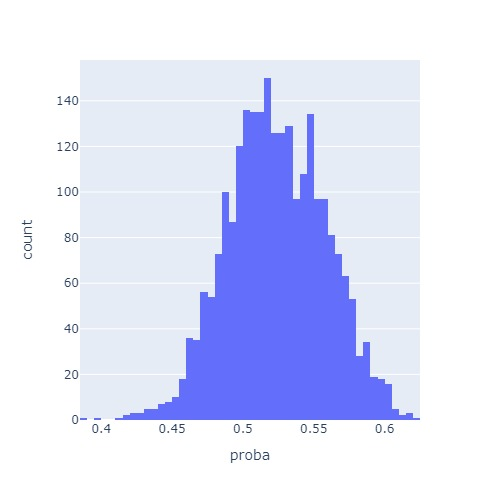

In [34]:
amazon['proba'] = model.predict(amazon[features])
fig = px.histogram(data_frame=amazon, x='proba',  width=500, height=500)
fig.show('jpeg')

In [35]:
amazon.loc[amazon['proba'] > 0.491, 'prediction'] = 1
amazon.loc[amazon['proba'] <= 0.491, 'prediction'] = 0

In [36]:
# Accuracy on the train set
accuracy_score(y_true=amazon.loc[y_train.index, 'target'], y_pred=amazon.loc[y_train.index, 'prediction']).round(4)

0.5433

In [37]:
# Accuracy on the test set
accuracy_score(y_true=amazon.loc[y_test.index, 'target'], y_pred=amazon.loc[y_test.index, 'prediction']).round(4)

0.5495

Accuracy on the test set reported in the paper is equal to `0.7330`, which is extremely different to `0.5495`. Maybe it's due to data leakage - let's find out.

In [38]:
amazon = read_data(file_path='AMZN.csv')
amazon = get_oscillators(df=amazon)
# Data leakage
amazon['target'] = (amazon['close'].diff().shift() > 0).astype(int)
features = ['const', 'macd', 'rsi', 'cmo', 'trix', 'dpo', 'roc']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(amazon[features], amazon['target'], train_size=0.7, shuffle=False)

In [40]:
model = Logit(endog=y_train, exog=X_train).fit(disp=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1743
Model:                          Logit   Df Residuals:                     1736
Method:                           MLE   Df Model:                            6
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.9520
Time:                        10:30:19   Log-Likelihood:                -57.932
converged:                       True   LL-Null:                       -1206.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5044      3.685     -0.137      0.891      -7.726       6.717
macd          -0.8347      1.500     -0.556      0.578      -3.775       2.106
rsi            0.0084      0.072      0.116      0.907      -0.133       0.149
cmo            0.0069      0.019      0.360      0.719      -0.031       0.045
trix           0.4192      2.240      0.187      0.852      -3.971       4.809
dpo            0.0236      0.559      0.042      0.966      -1.072       1.119
roc           26.8966      3.687      7.295      0.000      19.671      34.122
==============================================================================

Possibly complete quasi-separation: A fraction 0.82 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

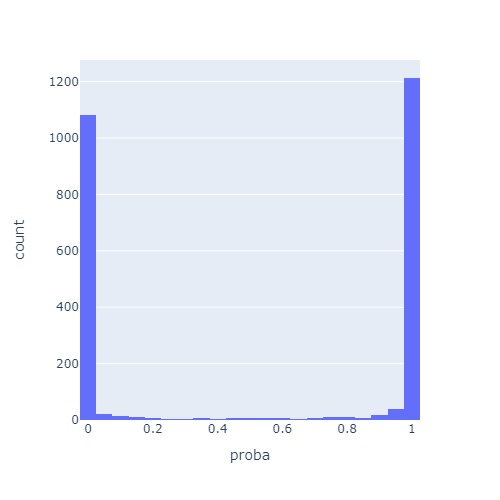

In [41]:
amazon['proba'] = model.predict(amazon[features])
fig = px.histogram(data_frame=amazon, x='proba',  width=500, height=500)
fig.show('jpeg')

In [42]:
amazon.loc[amazon['proba'] > 0.491, 'prediction'] = 1
amazon.loc[amazon['proba'] <= 0.491, 'prediction'] = 0

In [43]:
# Accuracy on the test set
accuracy_score(y_true=amazon.loc[y_test.index, 'target'], y_pred=amazon.loc[y_test.index, 'prediction']).round(4)

0.9947

To sum up, the reported test set accuracy is listed as `0.7330`, but I am unable to determine the source of this high accuracy due to the limited information provided. In my replication, I achieved a more realistic accuracy of `0.5495`. 